# LSTM Baseline Model Testing

## 0 Imports & Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from utilities import load_complete_time_series, split_data_into_sequences, reconstruct_sequential_data, Scaler, train_test_split, extract_features_and_targets
from LSTM import LSTM, train_model
from TimeSeriesDataset import TimeSeriesDataset
from mean_regressor import MeanRegressor

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = True

### Hyperparameters

In [5]:
SEQ_LEN = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [6]:
FEATURES = ['Close', 'Volume']

## 2 Data

### Data Loading

In [7]:
# Load data from csv
# -> convert Date column to datetime
data = load_complete_time_series(f'{REAL_DATA_FOLDER}/AAPL_complete_no_date.csv')
data = data[FEATURES] # remember to put the target column first
data[SEQ_LEN-1:SEQ_LEN+10]

,Close,Volume
14,0.150670,35728000
15,0.143973,45158400
16,0.137835,55686400
17,0.135045,39827200
18,0.142299,21504000
19,0.141183,23699200
20,0.136161,23049600
21,0.136719,14291200
22,0.139509,14067200
23,0.138393,13395200


In [8]:
data_numpy = data.to_numpy()

### Preprocessing for Dummy model

In [9]:
dummy_seq = split_data_into_sequences(data_numpy, SEQ_LEN)
dummy_train_seq, dummy_test_seq = train_test_split(dummy_seq, split_ratio=0.97)
dummy_X_test, dummy_y_test = extract_features_and_targets(dummy_test_seq)

Shape of the data after splitting into sequences: (10964, 15, 2)
Extracted features and target from training data.
Shape of X_train: torch.Size([329, 14, 2])
Shape of y_train: torch.Size([329, 1])


### Data Preprocessing

In [10]:
data_seq_shuffled = split_data_into_sequences(data_numpy, SEQ_LEN, shuffle_data=False)

Shape of the data after splitting into sequences: (10964, 15, 2)


In [11]:
data_train_seq, data_test_seq = train_test_split(data_seq_shuffled, split_ratio=0.90)
data_test_seq, data_val_seq = train_test_split(data_test_seq, split_ratio=0.5)

In [12]:
scaler = Scaler(data_train_seq)

In [13]:
data_train_seq_scaled = scaler.scale_data(data_train_seq)
data_test_seq_scaled = scaler.scale_data(data_test_seq)
data_val_seq_scaled = scaler.scale_data(data_val_seq)

In [14]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(data_train_seq_scaled, data_test_seq_scaled, data_val_seq_scaled)

In [15]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 14, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [18]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=X_train.shape[2], # number of features
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()

In [20]:
best_validation_loss, model = train_model(model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device)

Epoch: 1
Validation Loss: 1.3848274151484172
**************************************************
Epoch: 2
Validation Loss: 1.2407200005319383
**************************************************
Epoch: 3
Validation Loss: 1.0390578044785395
**************************************************
Epoch: 4
Validation Loss: 0.9282924930254618
**************************************************
Epoch: 5
Validation Loss: 0.8679463962713877
**************************************************
Epoch: 6
Validation Loss: 0.761445164680481
**************************************************
Epoch: 7
Validation Loss: 0.7307458056343926
**************************************************
Epoch: 8
Validation Loss: 0.6932740112145742
**************************************************
Epoch: 9
Validation Loss: 0.6842109461625417
**************************************************
Epoch: 10
Validation Loss: 0.6557618545161353
**************************************************
Epoch: 11
Validation Loss: 0.63747650053

## 4 Plot Predictions

### Inverse Transform

In [21]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [22]:
test_pred = scaler.inverse_scale_data(test_pred, feature_type='price')
train_pred = scaler.inverse_scale_data(train_pred, feature_type='price')
y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

In [23]:
loss = criterion_absolute(torch.tensor(test_pred), torch.tensor(y_test)).item()
loss

7.219221951844193

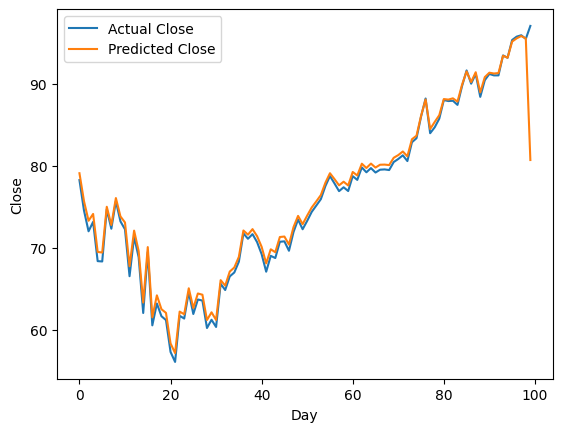

In [39]:
# plot test data
plt.plot(y_test[:100], label="Actual Close")
plt.plot(np.roll(test_pred[:100], -1), label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


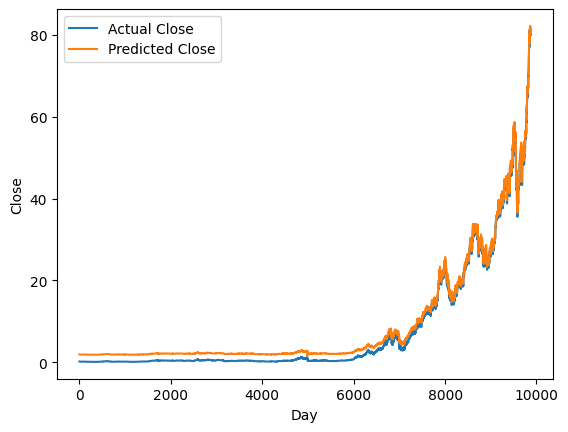

In [25]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


### Dummy Testing

In [26]:
dummy_model = MeanRegressor()
dummy_pred = dummy_model.make_predictions(dummy_X_test)

In [27]:
dummy_pred.shape

(329,)

In [28]:
loss = criterion_absolute(torch.tensor(dummy_pred), dummy_y_test).item()
loss

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([329, 1])) that is different to the input size (torch.Size([329])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


13.956390077236527

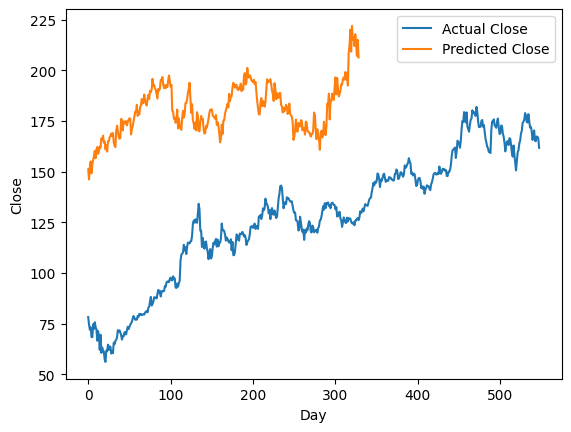

In [29]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(dummy_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()